<a href="https://colab.research.google.com/github/rmontenegroo/discursos/blob/main/nlp_discursos_camara_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulos

In [ ]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!pip install spacy==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 34.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [ ]:
!pip install pyLDAvis==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords

import os
import glob
import zlib
import base64
import pickle
import tqdm

import wordcloud

# Definições

In [ ]:
stopwords_ = stopwords.words('portuguese')
stopwords_.extend(
    [ 
      'sr', 'sra', 'srs', 'sras', 'a', 'e', 'o', 'as', 'os', 'da', 'de', 'do', 'das', 'dos', 'à', 'às', 'um', 'uma', 'uns', 'umas', 'ao', 'aos', \
      'presidente', 'quero', 'obrigado', 'importante', 'importantes', 'momento', 'governo', 'nº', 'parabéns', 'parabenizar', 'casa', 'deputado', \
      'deputados', 'agradecer', 'senhor', 'senhora', 'senhores', 'senhoras', \
    ]
)

ROOTDIR = '/content/drive/MyDrive/Pós/discursos/'

from google.colab import drive
drive.mount('/content/drive')

LEGISLATURA = 56
RANDOM_STATE = 12

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

# Carregando discursos

In [ ]:
if not os.path.isfile(ROOTDIR + f'data/tokens_{LEGISLATURA}.dat'):
  discursos = pd.read_json(ROOTDIR + 'data/sentences_discursos.json')
  discursos = discursos.drop(columns=['original'])
  discursos = discursos.loc[discursos.idLegislatura == LEGISLATURA] # usando a última legislatura por causa do limite de memória
  discursos['tokens'] = discursos.sentences.map(lambda d: [w for s in d for w in s]) # junta todos os tokens de um discurso
else:
  discursos = pd.DataFrame()

# Criando bigramas e trigramas

In [ ]:
if not os.path.isfile(ROOTDIR + f'data/bigramas_{LEGISLATURA}.dat'):
  bigramas = gensim.models.Phrases(discursos.tokens, min_count=10, threshold=100)

  with open(ROOTDIR + f'data/bigramas_{LEGISLATURA}.dat', 'wb') as fp:
    pickle.dump(bigramas, fp)

else:
  with open(ROOTDIR + f'data/bigramas_{LEGISLATURA}.dat', 'rb') as fp:
    bigramas = pickle.load(fp)

In [ ]:
if not os.path.isfile(ROOTDIR + f'data/trigramas_{LEGISLATURA}.dat'):
  trigramas = gensim.models.Phrases(bigramas[discursos.tokens], min_count=10, threshold=100)

  with open(ROOTDIR + f'data/trigramas_{LEGISLATURA}.dat', 'wb') as fp:
    pickle.dump(trigramas, fp)    

else:
  with open(ROOTDIR + f'data/trigramas_{LEGISLATURA}.dat', 'rb') as fp:
    trigramas = pickle.load(fp)

In [ ]:
if not os.path.isfile(ROOTDIR + f'data/bigrama_{LEGISLATURA}_model.dat'):
  bigrama_model = gensim.models.phrases.Phraser(bigramas)

  with open(ROOTDIR + f'data/bigrama_{LEGISLATURA}_model.dat', 'wb') as fp:
    pickle.dump(bigrama_model, fp)

else:
  with open(ROOTDIR + f'data/bigrama_{LEGISLATURA}_model.dat', 'rb') as fp:
    bigrama_model = pickle.load(fp)

In [ ]:
if not os.path.isfile(ROOTDIR + f'data/trigrama_{LEGISLATURA}_model.dat'):
  trigrama_model = gensim.models.phrases.Phraser(trigramas)

  with open(ROOTDIR + f'data/trigrama_{LEGISLATURA}_model.dat', 'wb') as fp:
    pickle.dump(trigrama_model, fp)

else:
  with open(ROOTDIR + f'data/trigrama_{LEGISLATURA}_model.dat', 'rb') as fp:
    trigrama_model = pickle.load(fp)

# Limpeza do texto


In [ ]:
nlp = spacy.load('pt_core_news_sm')

def clean_text(tokens):

  tokens = [tk for tk in tokens if len(tk) >= 2]

  tokens = [tk for tk in tokens if tk not in stopwords_]

  tokens = bigrama_model[tokens]

  tokens = trigrama_model[tokens]

  tokens = [(tk.text if tk.pos_ == 'NOUN' else tk.lemma_) for tk in nlp(" ".join(tokens)) if tk.pos_ in ('NOUN', 'VERB')]
  
  return tokens


if not os.path.isfile(ROOTDIR + f'data/tokens_{LEGISLATURA}.dat'):
  
  discursos['tokens_'] = discursos.tokens.map(clean_text)

  with open(ROOTDIR + f'data/tokens_{LEGISLATURA}.dat', 'wb') as fp:
    pickle.dump(discursos, fp)

else:
  with open(ROOTDIR + f'data/tokens_{LEGISLATURA}.dat', 'rb') as fp:
    discursos = pickle.load(fp)

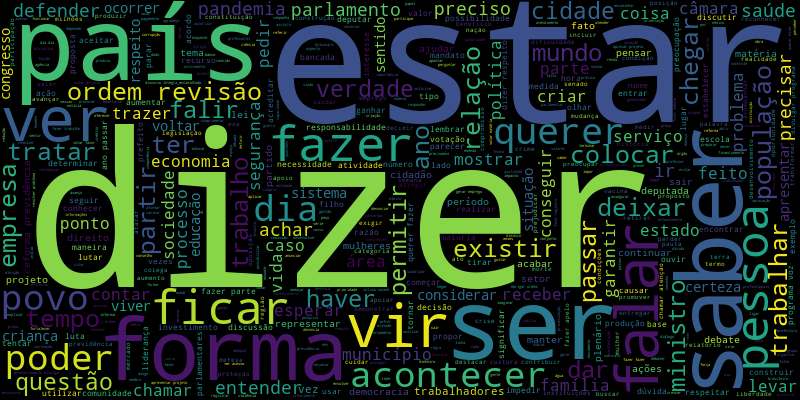

In [ ]:
wordcloud.WordCloud(width=800, height=400, max_words=500).generate_from_text(' '.join(discursos.tokens_.map(lambda ts: ' '.join(ts)))).to_image()

# Dicionário e Corpus

### Dicionário

In [ ]:
id2word = corpora.Dictionary(discursos.tokens_)
print('Palavras no dicionario:', len(id2word.token2id.keys()))
NO_BELOW=3
# NO_ABOVE=0.01 # => max coherence: 0.40
# NO_ABOVE=0.025 # => max coherence: 0.51
NO_ABOVE=0.05 # => max coherence: 0.59
# NO_ABOVE=0.1 # => max coherence: 0.52
# NO_ABOVE=0.2 # => max coherence: 0.52
# NO_ABOVE=0.4 # => max coherence: 0.44
# NO_ABOVE=0.8 # => max coherence: 0.426
id2word.filter_extremes(no_below=NO_BELOW, no_above=NO_ABOVE)
print('Palavras no dicionario:', len(id2word.token2id.keys()))

Palavras no dicionario: 45984
Palavras no dicionario: 23622


### Remove os tokens mais frequentes

In [ ]:
discursos['tokens_'] = discursos.tokens_.map(lambda ts: [t for t in ts if id2word.token2id.get(t, False)])

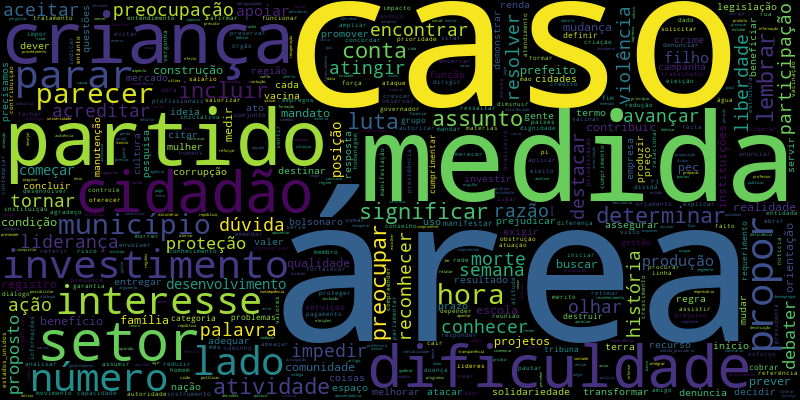

In [ ]:
wordcloud.WordCloud(width=800, height=400, max_words=500).generate_from_text(' '.join(discursos.tokens_.map(lambda ts: ' '.join(ts)))).to_image()

### Corpus

In [ ]:
corpus = [id2word.doc2bow(d) for d in discursos.tokens_.values]

# LDA

### Busca de hiperparâmetros

In [ ]:
# K topicos
# start_k = 2
# end_k = 50
# pace = 1
# k_list = range(start_k, end_k+pace, pace)

k_list = [12]

print(len(k_list))

1


In [ ]:
# Alpha
# alpha = [0.01, 0.5, 1]
# alpha.append('symmetric')
# alpha.append('asymmetric')

alpha = [1]

print(len(alpha))

1


In [ ]:
# Beta
# beta = [0.01, 0.5, 1]
# beta.append('symmetric')

beta = [0.5]

print(len(beta))


1


In [ ]:
# chunksize=100,
# passes=10,

def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k, 
        random_state=RANDOM_STATE,        
        alpha=a,
        eta=b
    )
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=discursos.tokens_, dictionary=id2word, coherence='c_v')
    
    return lda_model, coherence_model_lda.get_coherence()

In [ ]:
if not os.path.isfile(ROOTDIR + f'data/lda_model_{LEGISLATURA}.dat'):

  history = {
      'k': [],
      'alpha': [],
      'beta': [],
      'coherence_score': [],
  }

  pbar = tqdm.tqdm(total=len(alpha)*len(beta)*len(k_list))

  last_cv = 0

  for k in k_list:
    for a in alpha:
      for b in beta:

        lda_model, cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k, a=a, b=b)

        if cv > last_cv:
          last_cv = cv
          
          with open(ROOTDIR + f'data/lda_model_{LEGISLATURA}.dat', 'wb') as fp:
            pickle.dump(lda_model, fp)

        history['k'].append(k)
        history['alpha'].append(a)
        history['beta'].append(b)
        history['coherence_score'].append(cv)

        pbar.update(1)

  pbar.close()

  history = pd.DataFrame(history)
  history.to_json(ROOTDIR + f'data/history_lda_model_{LEGISLATURA}.json')

else:

  with open(ROOTDIR + f'data/lda_model_{LEGISLATURA}.dat', 'rb') as fp:
    lda_model = pickle.load(fp)

  history = pd.read_json(ROOTDIR + f'data/history_lda_model_{LEGISLATURA}.json')


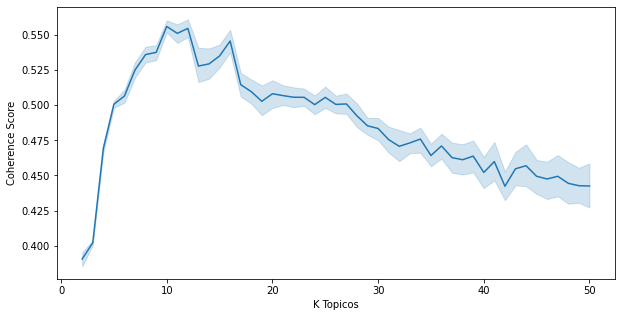

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x='k', y='coherence_score', data=history)
plt.xlabel("K Topicos")
plt.ylabel("Coherence Score")
plt.show()

In [ ]:
history.sort_values(by='coherence_score', ascending=False).iloc[0]

k                        12
alpha                     1
beta                    0.5
coherence_score    0.586811
Name: 209, dtype: object

### Visualizando distribuição e tópicos

In [ ]:
with open(ROOTDIR + f'data/lda_model_{LEGISLATURA}.dat', 'rb') as fp:
  best_lda_model = pickle.load(fp)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_lda_model, corpus, id2word, mds='mmds')
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.278674  0.042000       1        1  12.361586
11    -0.054181  0.253105       2        1  10.732300
8      0.242963 -0.082029       3        1   9.039658
2     -0.093831  0.159650       4        1   8.546988
1      0.196090  0.070804       5        1   7.967703
0      0.132712  0.191511       6        1   7.927230
7     -0.077509 -0.077632       7        1   7.806800
6     -0.072353 -0.218953       8        1   7.753604
4     -0.187647 -0.113193       9        1   7.753008
5      0.076646 -0.217708      10        1   7.111462
10     0.027682  0.086757      11        1   7.100149
9      0.088104 -0.094312      12        1   5.899513, topic_info=            Term         Freq        Total Category  logprob  loglift
83     violência  4686.000000  4686.000000  Default  30.0000  30.0000
1902    crianças  5861.000000  5861.000000  Default  29.0000  29.0000
307        preço  4623.000000  4623.000000  Default  28.0000  28.0000
371    município  4272.000000  4272.000000  Default  27.0000  27.0000
169        setor  4316.000000  4316.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
601        abrir   575.113255  3372.091788  Topic12  -5.5459   1.0616
713   interesses   514.479979  2159.611240  Topic12  -5.6573   1.3958
805        conta   501.936790  2264.839820  Topic12  -5.6820   1.3235
1410   preocupar   498.006908  3796.186921  Topic12  -5.6898   0.7992
394        parar   474.810208  4556.218670  Topic12  -5.7375   0.5690

[774 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
5293      1  0.003269             abençoar
5293      2  0.003269             abençoar
5293      3  0.022886             abençoar
5293      4  0.003269             abençoar
5293      5  0.006539             abençoar
...     ...       ...                  ...
3373      8  0.028141  íntegra_encaminhado
3373      9  0.004503  íntegra_encaminhado
3373     10  0.028141  íntegra_encaminhado
3373     11  0.003940  íntegra_encaminhado
3373     12  0.018573  íntegra_encaminhado

[8485 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 12, 9, 3, 2, 1, 8, 7, 5, 6, 11, 10])

## Inferir tópicos de determinado discurso

In [ ]:
um_discurso = discursos.sample(1)
um_discurso_bow = id2word.doc2bow(
    um_discurso.tokens_.values[0]
)

for topicid, pt in sorted(best_lda_model[um_discurso_bow], key=lambda i: i[1], reverse=True):
  print([id2word[wordid] for wordid, pw in best_lda_model.get_topic_terms(topicid)], f'{pt*100:.2f}%')

print("\n" + "\n".join([" ".join(ss) for ss in um_discurso.sentences.values[0]]))

['preço', 'setor', 'produção', 'produzir', 'mercado', 'crédito', 'petrobras', 'preços', 'produtos', 'indústria'] 18.27%
['entregar', 'empresa', 'vender', 'água', 'privatização', 'saneamento', 'serviços', 'privatizar', 'lucro', 'correios'] 18.13%
['aposentar', 'pec', 'trabalhador', 'reais', 'contribuição', 'salário', 'pagamento', 'benefício', 'inflação', 'auxílio'] 17.69%
['vacinar', 'vacinação', 'morrer', 'mortes', 'vacinas', 'vacina', 'profissionais', 'covid', 'tratamento', 'número'] 16.31%
['corrupção', 'liberdade', 'atacar', 'eleição', 'crime', 'cometer', 'eleições', 'investigar', 'prisão', 'mandato'] 8.35%
['violência', 'mulher', 'povos_indígenas', 'proteção', 'denunciar', 'matar', 'ação', 'terra', 'atingir', 'crime'] 5.74%
['município', 'região', 'prefeito', 'áreas', 'cidades', 'área', 'obras', 'desenvolvimento', 'infraestrutura', 'investimentos'] 3.73%
['emendar', 'prazo', 'legislação', 'prever', 'mérito', 'emendas', 'parecer', 'alterar', 'incluir', 'propor'] 3.16%
['partido', 'c